# Building LLM From Scratch

This code is adapted from a freeCodeCamp YouTube tutorial, which you can watch [here](https://www.youtube.com/watch?v=UU1WVnMk4E8). Note that this version is not identical to the [code](https://github.com/Infatoshi/fcc-intro-to-llms) provided in the tutorial. I have made some changes just because. also working on a mac

needed to remove the prefix and suffix from The Project Gutenberg in the text


## Imports

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional  as F
import os

from matplotlib import pyplot as plt



## Global Var/hyperparameters

In [2]:
config = {}
config['block_size'] = 64
config['batch_size'] = 128
config['epoch'] = 1000
config['learning_rate'] = 1e-3 #3e-3, 3e-4, 1e-3,1e-4
config['eval_iters'] = 250
config['n_embd'] = 512
config['n_head'] = 4
config['n_layer'] = 4
config['dropout'] = 0.2
config['device'] = torch.device('cpu') # set as default

## Device

In [3]:
# Set device based on availability
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA (GPU)")
elif torch.backends.mps.is_available():
    device = torch.device('mps')  # Assuming first GPU if MPS is available
    print("Using MPS")
else:
    device = torch.device('cpu')
    print("Using CPU")

print("Device:", device)

config['device'] = device

Using MPS
Device: mps


## Dataset

In [4]:
# Initialize an empty string to hold all the text
all_text = ""

# Path to the directory containing the book files
books_dir = 'books'

# Loop through each file in the directory
for filename in os.listdir(books_dir):
    if filename.endswith('.txt'):
        with open(os.path.join(books_dir, filename), 'r', encoding='utf-8') as f:
            # Read the content of the file and append it to all_text
            all_text += f.read() + " "  # Add a 
    
vocab = sorted(set(all_text))
config['vocab_size'] = len(vocab)
print(vocab)
print("length of text:",len(all_text))
print(f"Set of characters: {config['vocab_size']}")
#print("First Fifty Characters:\n", text[:50])

['\t', '\n', ' ', '!', '"', '$', '&', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '£', '°', '´', '·', 'À', 'Á', 'Æ', 'Ç', 'É', 'à', 'á', 'â', 'ä', 'æ', 'ç', 'è', 'é', 'ê', 'ë', 'í', 'î', 'ï', 'ó', 'ô', 'ö', 'ú', 'û', 'ü', 'ý', 'Œ', 'œ', 'Φ', 'α', 'η', 'λ', 'μ', 'ν', 'ξ', 'ο', 'ρ', 'ς', 'τ', 'ϰ', 'ו', 'ח', 'ὁ', 'ὑ', '—', '‘', '’', '“', '”', '…', '─', '❧', '\ufeff']
length of text: 11770361
Set of characters: 140


In [5]:
string_to_int = {ch:i for i,ch in enumerate(vocab)}
int_to_string = {i:ch for i,ch in enumerate(vocab)}

def encoder(string:str):
    
    return [string_to_int[ch] for ch in string]

def decoder(vector):
    
    return " ".join([int_to_string[i] for i in vector])
    
    
data = torch.tensor(encoder(all_text),dtype=torch.long)

## Train/Validation split

In [6]:
# Split the data into training and validation sets
n = int(0.8 * len(data))
train_data = data[:n]
val_data = data[n:]

def get_batch(split):
    """
    Function to generate a batch of data.
    
    Parameters:
    - split (str): 'train' or 'val' to specify which dataset to use.
    
    Returns:
    - x (Tensor): Input tensor of shape (batch_size, block_size).
    - y (Tensor): Target tensor of shape (batch_size, block_size).
    """
    # Select the appropriate dataset based on the split
    data = train_data if split == 'train' else val_data
    
    # Randomly choose starting indices for the batch
    ix = torch.randint(len(data) - config['block_size'], (config['batch_size'],))
    
    # Generate the input (x) and target (y) tensors
    x = torch.stack([data[i:i + config['block_size']] for i in ix])
    y = torch.stack([data[i + 1:i + config['block_size'] + 1] for i in ix])
    
    # Move the tensors to the specified device (CPU, CUDA, or MPS)
    x, y = x.to(config['device']), y.to(config['device'])
    
    return x, y

# Example usage: Get a batch from the training data
x, y = get_batch('train')

# Display the input and target tensors
print('Inputs:')
print(x)
print('Targets:')
print(y)


Inputs:
tensor([[ 58,  76,   2,  ...,   2,  64,  58],
        [ 58,  78,  64,  ...,   2,   2,   2],
        [ 65,  62,  75,  ...,  61,   2, 132],
        ...,
        [ 47,  40,  33,  ...,  77,   2,  66],
        [ 75,  82,   2,  ...,   2,  80,  62],
        [ 76,  77,  75,  ...,  48,  65,  82]], device='mps:0')
Targets:
tensor([[ 76,   2,  77,  ...,  64,  58,  66],
        [ 78,  64,  65,  ...,   2,   2,  41],
        [ 62,  75,   2,  ...,   2, 132,  48],
        ...,
        [ 40,  33,  42,  ...,   2,  66,  77],
        [ 82,   2,  65,  ...,  80,  62,  58],
        [ 77,  75,  58,  ...,  65,  82,   2]], device='mps:0')


## Model

In [7]:
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)
        
        
    def forward(self, index, targets=None):
        logits = self.token_embedding_table(index)
        
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    
    def generate(self, index, max_new_tokens):
        for _ in range(max_new_tokens):
            logits, _ = self(index)  # Call model directly instead of forward
            logits = logits[:, -1, :]  # Focus on the last time step
            probs = F.softmax(logits, dim=-1)  # Get probabilities
            index_next = torch.multinomial(probs, num_samples=1)  # Sample from distribution
            index = torch.cat((index, index_next), dim=1)  # Append sampled index
        return index

model = BigramLanguageModel(config['vocab_size'])
m = model.to(device)

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(config['eval_iters'])
        for k in range(config['eval_iters']):
            X, Y = get_batch(split)
            _, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        Args:
            patience (int): How many epochs to wait after last time the validation loss improved.
                            Default: 5
            min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                               Default: 0
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


In [8]:
# Initialize the early stopping object
early_stopping = EarlyStopping(patience=3, min_delta=0.001)

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=config['learning_rate'])

# Initialize lists to store the losses
train_losses = []
val_losses = []

for iter in range(config['epoch']):
    if iter % config['eval_iters'] == 0:
        losses = estimate_loss()
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])

        print(f"step: {iter}, train loss: {losses['train']:.3f}, val loss: {losses['val']:.3f}")


       # Check for early stopping
        early_stopping(losses['val'])
        
        if early_stopping.early_stop:
            print("Early stopping triggered. Stopping training.")
            break
        
        
    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model.forward(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# Print the final loss value
print(f"Final loss: {loss.item():.3f}")


step: 0, train loss: 5.415, val loss: 5.396
step: 250, train loss: 5.014, val loss: 5.004
step: 500, train loss: 4.648, val loss: 4.644
step: 750, train loss: 4.319, val loss: 4.319
Final loss: 4.036


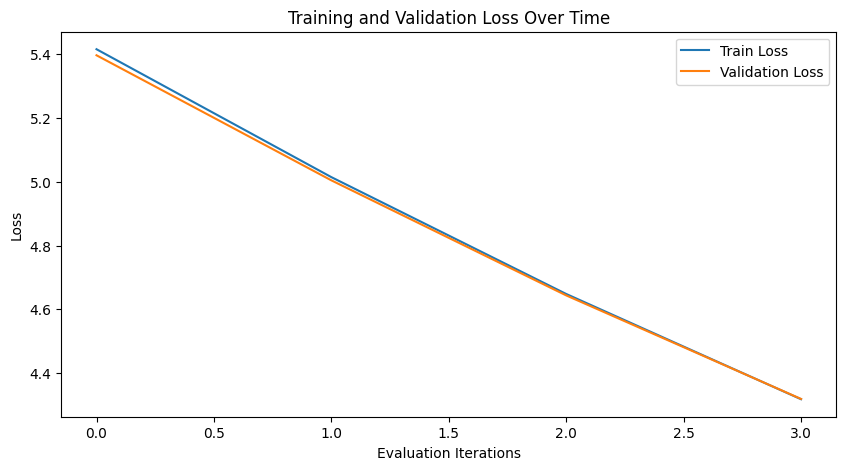

In [9]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Evaluation Iterations')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()


In [10]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(config['n_embd'], head_size, bias=False)
        self.query = nn.Linear(config['n_embd'], head_size, bias=False)
        self.value = nn.Linear(config['n_embd'], head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(config['block_size'], config['block_size'])))

        self.dropout = nn.Dropout(config['dropout'])

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, config['n_embd'])
        self.dropout = nn.Dropout(config['dropout'])

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1) # (B, T, F) -> (B, T, [h1, h1, h1, h1, h2, h2, h2, h2, h3, h3, h3, h3])
        out = self.dropout(self.proj(out))
        return out
    

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(config['dropout']),
        )

    def forward(self, x):
        return self.net(x)
    
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        y = self.sa(x)
        x = self.ln1(x + y)
        y = self.ffwd(x)
        x = self.ln2(x + y)
        return x
    
class GPTLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, config['n_embd'])
        self.position_embedding_table = nn.Embedding(config['block_size'], config['n_embd'])
        self.blocks = nn.Sequential(*[Block(config['n_embd'], n_head=config['n_head']) for _ in range(config['n_layer'])])
        self.ln_f = nn.LayerNorm(config['n_embd']) # final layer norm
        self.lm_head = nn.Linear(config['n_embd'], vocab_size)
        
        
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, index, targets=None):
        B, T = index.shape
        
        
        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(index) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)
        
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    
    def generate(self, index, max_new_tokens):
        # index is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            index_cond = index[:, -config['block_size']:]
            # get the predictions
            logits, loss = self.forward(index_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            index_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            index = torch.cat((index, index_next), dim=1) # (B, T+1)
        return index

In [11]:
# context = torch.randint(5,(1,1), dtype=torch.long, device=device)
# generated_chars = decoder(m.generate(context, max_new_tokens=500)[0].tolist())
# print(generated_chars)

In [12]:
from transformers import GPT2Tokenizer
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import pandas as pd
import torch
from datasets import Dataset
from transformers import AdamW, get_linear_schedule_with_warmup

# Load the dataset
dataset = load_dataset("openwebtext")

# Select a portion of the dataset (e.g., 1% of the data)
subset_size = 0.01  # Use 1% of the dataset
num_samples = int(len(dataset['train']) * subset_size)
dataset = dataset['train'].shuffle(seed=42).select(range(num_samples))

# Initialize the tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
# Define a function to tokenize the data
def tokenize_function(examples):
    return tokenizer(
        examples['text'], 
        padding='max_length', 
        truncation=True, 
        max_length=config['block_size']
    )

# Apply the tokenization function to the dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True, remove_columns=["text"])

# Convert tokenized datasets to DataFrame
train_df = pd.DataFrame(tokenized_datasets)

# Split the dataset into training and validation + test sets
train_df, val_test_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Split the remaining dataset into validation and test sets
val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=42)

# Convert DataFrames back to Dataset objects
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

    
def collate_fn(batch):
    return {
        'input_ids': torch.tensor([item['input_ids'] for item in batch], device=config['device']),
        'attention_mask': torch.tensor([item['attention_mask'] for item in batch], device=config['device']),
        'labels': torch.tensor([item['input_ids'] for item in batch], device=config['device'])  # GPT models use input_ids as labels
    }

train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, collate_fn=collate_fn)

# Initialize the model
model = GPTLanguageModel(config['vocab_size']).to(config['device'])
optimizer = AdamW(model.parameters(), lr=config['learning_rate'])

# Define the scheduler
total_steps = len(train_dataloader) * config['epoch']
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

def train():
    model.train()
    for epoch in range(config['epoch']):
        for batch in train_dataloader:
            inputs = {key: value.to(config['device']) for key, value in batch.items()}
            optimizer.zero_grad()
            outputs, loss = model(inputs['input_ids'], targets=inputs['labels'])
            loss.backward()
            optimizer.step()
            scheduler.step()
            print(f"Epoch {epoch}, Loss: {loss.item()}")

def evaluate(dataloader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in dataloader:
            inputs = {key: value.to(config['device']) for key, value in batch.items()}
            _, loss = model(inputs['input_ids'], targets=inputs['labels'])
            total_loss += loss.item()
    return total_loss / len(dataloader)

# Training and evaluation
train()
val_loss = evaluate(val_dataloader)
print(f"Validation Loss: {val_loss}")

test_loss = evaluate(test_dataloader)
print(f"Test Loss: {test_loss}")


/Users/rhysjervis/Documents/Code/llm scratch/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/rhysjervis/Documents/Code/llm scratch/.venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Map: 100%|██████████| 80137/80137 [03:11<00:00, 419.34 examples/s]
/Users/rhysjervis/Documents/Code/llm scratch/.venv/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use t

Epoch 0, Loss: 0.537350594997406
Epoch 0, Loss: 0.19764503836631775
Epoch 0, Loss: 0.19060742855072021
Epoch 0, Loss: 0.1265326738357544
Epoch 0, Loss: 0.07955832779407501
Epoch 0, Loss: 0.06268519163131714
Epoch 0, Loss: 0.04816161096096039
Epoch 0, Loss: 0.051472894847393036
Epoch 0, Loss: 0.040444016456604004
Epoch 0, Loss: 0.03215932846069336
Epoch 0, Loss: 0.023623641580343246
Epoch 0, Loss: 0.021853934973478317
Epoch 0, Loss: 0.017770998179912567
Epoch 0, Loss: 0.03132965415716171
Epoch 0, Loss: 0.010253394953906536
Epoch 0, Loss: 0.00789475068449974
Epoch 0, Loss: 0.007928013801574707
Epoch 0, Loss: 0.005941067822277546
Epoch 0, Loss: 0.005053386092185974
Epoch 0, Loss: 0.01411827839910984
Epoch 0, Loss: 0.001773735973984003
Epoch 0, Loss: 0.007491584867238998
Epoch 0, Loss: 0.003719297470524907
Epoch 0, Loss: 0.002644382882863283
Epoch 0, Loss: 0.0015240911161527038
Epoch 0, Loss: 0.0037185698747634888
Epoch 0, Loss: 0.002955026924610138
Epoch 0, Loss: 0.0018052953528240323
Epo

KeyboardInterrupt: 